In [1]:
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [2]:
DATA_ROOT = Path("../data")

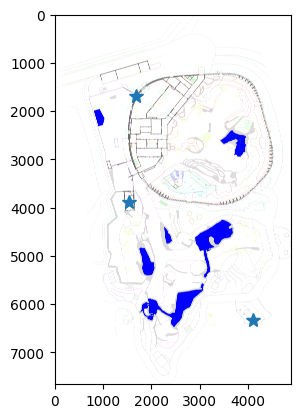

In [ ]:
# Map to world constraints
@dataclass
class WorldMapConstraints:
    world2_points: np.ndarray
    map_points: np.ndarray


map_constraints = WorldMapConstraints(
    world2_points=np.array([(-73.29, 55.69), (-77.21, -6.51), (-4.88, -75.34)]),
    map_points=np.array([(1682, 1683), (1543, 3886), (4106, 6327)]),
)


def imread_rgb(name):
    m = cv2.imread(name)
    return cv2.cvtColor(m, cv2.COLOR_BGR2RGB)


map_file = "kkep_floorplan.png"
im_map = imread_rgb(DATA_ROOT / map_file)
plt.imshow(im_map)
plt.plot(
    map_constraints.map_points[:, 0],
    map_constraints.map_points[:, 1],
    "*",
    markersize=10,
)

In [ ]:
# Homogenous coordinates utilities
def to_h(x, hvalue=1):
    if len(x.shape) == 1:
        return np.concatenate([x, np.full((1,), hvalue)])
    else:
        count = x.shape[0]
        return np.concatenate([x, np.full((count, 1), hvalue)], axis=1)


def from_h(x):
    if len(x.shape) == 1:
        return x[0:-1] / x[-1]
    else:
        return x[:, 0:-1] / x[:, [-1]]


def hmult(A, b, keep_h=False):
    np.testing.assert_equal(len(A.shape), 2)
    np.testing.assert_equal(A.shape[1], b.shape[-1] + 1)
    bh = to_h(b)
    Abh = (A @ bh.T).T
    if not keep_h:
        return from_h(Abh)
    else:
        return Abh


print("Homogenous utilities tests")
a2 = np.array([[0, 0], [1, 1], [2, 2], [3, 3]])
print(to_h(a2))
print(from_h(to_h(a2)))
A = np.eye(3)
hmult(A, np.ones((2,)))
hmult(A, np.ones((10, 2)))

Homogenous utilities tests
[[0 0 1]
 [1 1 1]
 [2 2 1]
 [3 3 1]]
[[0. 0.]
 [1. 1.]
 [2. 2.]
 [3. 3.]]


array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [ ]:
# Map to world calibration
from optimization_helpers import optimizeModel, IModelEvaluator


class Similarity2DEvaluator(IModelEvaluator[np.ndarray]):
    def __init__(self, points_a: np.ndarray, points_b: np.ndarray):
        super().__init__()
        count, _ = points_a.shape
        assert points_a.shape == (count, 2)
        assert points_a.shape == points_b.shape

        self.points_a = points_a
        self.points_b = points_b

    def model2params(self, model: np.ndarray) -> np.ndarray:
        return np.array([model[0, 0], model[1, 1], model[0, 2], model[1, 2]])

    def params2model(self, params: np.ndarray) -> np.ndarray:
        return np.array(
            [[params[0], 0, params[2]], [0, params[1], params[3]], [0, 0, 1]]
        )

    def getParamBounds(self) -> None:
        return None

    def evaluateModel(self, model: np.ndarray) -> float:
        points_aa = hmult(model, self.points_b)
        cost = np.sum(np.linalg.norm(points_aa - self.points_a, axis=1))
        return cost


evaluator = Similarity2DEvaluator(
    map_constraints.map_points, map_constraints.world2_points
)
m0 = np.array([[1, 0, 0], [0, 1, 0]])
display(evaluator.evaluateModel(m0))
T_map_from_world2 = optimizeModel(evaluator, m0, debug=True)
display("")
print(f"Final error in pixels: {evaluator.evaluateModel(T_map_from_world2)}")
print(f"{T_map_from_world2=}")
T_world2_from_map = np.linalg.inv(T_map_from_world2)
print(f"{T_world2_from_map=}")

np.float64(14089.47791340048)

         Current function value: 1.512272
         Iterations: 96
         Function evaluations: 966
         Gradient evaluations: 191
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1.5122718428351343
        x: [ 3.543e+01 -3.544e+01  4.279e+03  3.657e+03]
      nit: 96
      jac: [-1.424e+01  1.231e+01  1.023e+00  9.275e-01]
 hess_inv: [[ 5.132e-10 -1.240e-10  1.647e-09 -5.617e-09]
            [-1.240e-10  2.029e-10 -1.331e-09  5.206e-09]
            [ 1.647e-09 -1.331e-09  3.792e-08 -8.346e-08]
            [-5.617e-09  5.206e-09 -8.346e-08  5.318e-07]]
     nfev: 966
     njev: 191
Optimization cost: start=14089.47791340048, delta=-14087.965641557645


/home/dherrera/git/zoo_vision/env/lib/python3.11/site-packages/scipy/optimize/_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


''

Final error in pixels: 1.5122718428351343
T_map_from_world2=array([[ 3.54334161e+01,  0.00000000e+00,  4.27891507e+03],
       [ 0.00000000e+00, -3.54422652e+01,  3.65677974e+03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])
T_world2_from_map=array([[ 2.82219472e-02,  0.00000000e+00, -1.20759315e+02],
       [-0.00000000e+00, -2.82149009e-02,  1.03175678e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])


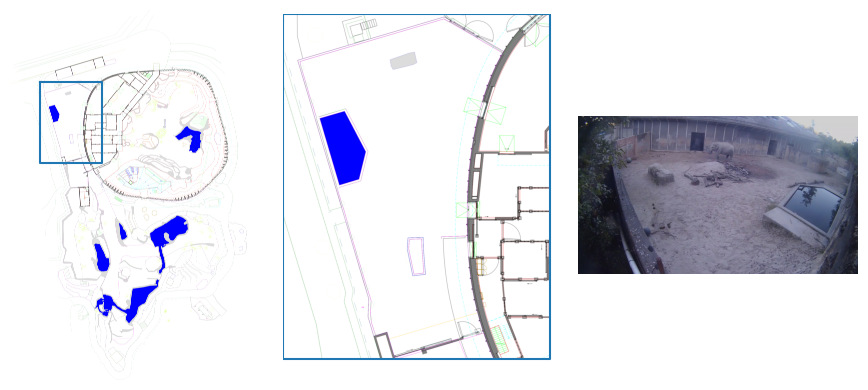

In [ ]:
# Get submap for specific camera
from glob import glob

camera_name = "Kamera 01"
submap_xy = np.array([626, 1500])
submap_end = np.array([1912, 3164])

im_submap = im_map[submap_xy[1] : submap_end[1], submap_xy[0] : submap_end[0], :]
T_submap_from_world2 = T_map_from_world2.copy()
T_submap_from_world2[0, 2] -= submap_xy[0]
T_submap_from_world2[1, 2] -= submap_xy[1]
T_world2_from_submap = np.linalg.inv(T_submap_from_world2)

submap_corners_in_map = np.stack([submap_xy, submap_end])
submap_corners_in_world2 = hmult(T_world2_from_map, submap_corners_in_map)
submap_corners_in_submap = hmult(T_submap_from_world2, submap_corners_in_world2)


def plot_rectangle_xyxy(ax, points):
    x0, y0 = points[0, 0:2]
    x1, y1 = points[1, 0:2]
    ax.plot([x0, x0, x1, x1, x0], [y0, y1, y1, y0, y0], "-")


image_filename = DATA_ROOT.glob(f"cameras/{camera_name}/*.jpg").__next__()
image_filename = image_filename.relative_to(DATA_ROOT)
im_camera = imread_rgb(DATA_ROOT / image_filename)
height, width, _ = im_camera.shape

fig, axs = plt.subplots(1, 3, figsize=(9, 4))
axs[0].imshow(im_map)
plot_rectangle_xyxy(axs[0], submap_corners_in_map)
axs[1].imshow(im_submap)
plot_rectangle_xyxy(axs[1], submap_corners_in_submap)
axs[2].imshow(im_camera)
for ax in axs:
    ax.set_axis_off()
fig.tight_layout()

In [7]:
@dataclass
class CameraConstraints:
    camera_points: np.ndarray
    world_points: np.ndarray
    floor_polygon_in_camera: np.ndarray


all_camera_constraints = {
    "Kamera 01": CameraConstraints(
        camera_points=np.array(
            [
                [558, 470],
                [502, 236],
                [769, 245],
                [861, 249],
                [1295, 277],
                [1353, 283],
                [1565, 358],
                [1708, 388],
                [1259, 732],
                [1615, 965],
            ]
        ),
        world_points=np.array(
            [
                [-88.52985154, 54.58961867, 0.0],
                [-73.31822199, 55.5207104, 0.0],
                [-75.97108503, 48.97485339, 0.0],
                [-76.62018982, 46.85873582, 0.0],
                [-77.97484329, 35.20598175, 0.0],
                [-78.05950913, 33.14629398, 0.0],
                [-84.04256194, 30.40944859, 0.0],
                [-85.42543735, 25.21790683, 0.0],
                [-94.96445551, 48.94663849, 0.0],
                [-98.85908422, 48.04376166, 0.0],
            ]
        ),
        floor_polygon_in_camera=np.array(
            [
                (628, 1073),
                (430, 741),
                (299, 417),
                (273, 337),
                (498, 236),
                (768, 245),
                (861, 251),
                (1298, 278),
                (1357, 284),
                (1411, 291),
                (1492, 328),
                (1564, 366),
                (1648, 401),
                (1707, 390),
                (1750, 375),
                (1838, 422),
                (1860, 456),
                (1831, 549),
                (1697, 475),
                (1516, 457),
                (1368, 611),
                (1269, 672),
                (1259, 723),
                (1621, 973),
                (1578, 1074),
            ]
        ),
    )
}
camera_constraints = all_camera_constraints.get(camera_name, None)
camera_points = None
world_points = None
floor_polygon_in_camera = None
if camera_constraints:
    camera_points = camera_constraints.camera_points
    world_points = camera_constraints.world_points
    floor_polygon_in_camera = camera_constraints.floor_polygon_in_camera
print(camera_constraints)

CameraConstraints(camera_points=array([[ 558,  470],
       [ 502,  236],
       [ 769,  245],
       [ 861,  249],
       [1295,  277],
       [1353,  283],
       [1565,  358],
       [1708,  388],
       [1259,  732],
       [1615,  965]]), world_points=array([[-88.52985154,  54.58961867,   0.        ],
       [-73.31822199,  55.5207104 ,   0.        ],
       [-75.97108503,  48.97485339,   0.        ],
       [-76.62018982,  46.85873582,   0.        ],
       [-77.97484329,  35.20598175,   0.        ],
       [-78.05950913,  33.14629398,   0.        ],
       [-84.04256194,  30.40944859,   0.        ],
       [-85.42543735,  25.21790683,   0.        ],
       [-94.96445551,  48.94663849,   0.        ],
       [-98.85908422,  48.04376166,   0.        ]]), floor_polygon_in_camera=array([[ 628, 1073],
       [ 430,  741],
       [ 299,  417],
       [ 273,  337],
       [ 498,  236],
       [ 768,  245],
       [ 861,  251],
       [1298,  278],
       [1357,  284],
       [1411,  291

In [ ]:
# Helper class to click on images
class MouseHandler:
    def __init__(self, img: np.ndarray, window_name: str, is_polygon: bool = False):
        self.img = img.copy()
        self.window_name = window_name
        self.is_polygon = is_polygon
        self.positions = []

    def start(self):
        cv2.namedWindow(self.window_name)
        cv2.setMouseCallback(self.window_name, self)
        cv2.imshow(self.window_name, self.img)

    def __call__(self, event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            self.positions.append((x, y))
            count = len(self.positions)
            if self.is_polygon:
                color = [0, 0, 200]
            else:
                color = [0, 0, 0]
                color[count % 3] = 200
            self.img = cv2.circle(self.img, (x, y), radius=10, color=color, thickness=5)
            if count > 1 and self.is_polygon:
                prev_x, prev_y = self.positions[count - 2]
                self.img = cv2.line(
                    self.img, (x, y), (prev_x, prev_y), color=color, thickness=3
                )
            cv2.imshow(self.window_name, self.img)

In [9]:
# Draw floor polygon in camera
if floor_polygon_in_camera is None:
    camera_clicker = MouseHandler(im_camera, f"camera: {camera_name}", is_polygon=True)
    cv2.startWindowThread()
    camera_clicker.start()
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    floor_polygon_in_camera = camera_clicker.positions
print("Floor polygon:")
display(floor_polygon_in_camera)

Floor polygon:


array([[ 628, 1073],
       [ 430,  741],
       [ 299,  417],
       [ 273,  337],
       [ 498,  236],
       [ 768,  245],
       [ 861,  251],
       [1298,  278],
       [1357,  284],
       [1411,  291],
       [1492,  328],
       [1564,  366],
       [1648,  401],
       [1707,  390],
       [1750,  375],
       [1838,  422],
       [1860,  456],
       [1831,  549],
       [1697,  475],
       [1516,  457],
       [1368,  611],
       [1269,  672],
       [1259,  723],
       [1621,  973],
       [1578, 1074]])

In [ ]:
# Click on correspondences between submap and camera
if camera_points is None or world_points is None:
    submap_clicker = MouseHandler(im_submap, "submap")
    camera_clicker = MouseHandler(im_camera, f"camera: {camera_name}")

    cv2.startWindowThread()
    submap_clicker.start()
    camera_clicker.start()

    key = cv2.waitKey(0)
    cv2.destroyAllWindows()

    camera_points = np.array(camera_clicker.positions)
    submap_points = np.array(submap_clicker.positions)
    world2_points = hmult(T_world2_from_submap, submap_points)
    world_points = to_h(world2_points, 0)
else:
    world2_points = world_points[:, 0:2]
    submap_points = hmult(T_submap_from_world2, world2_points)

print("World points:")
display(world_points)
print("Camera points:")
display(camera_points)

World points:


(10, 3)

Camera points:


(10, 2)

In [11]:

# Find homography through OpenCV
camera_constraints = CameraConstraints( camera_points = camera_points, world_points=world_points, floor_polygon_in_camera=floor_polygon_in_camera)
print(camera_constraints)

H_world2_from_camera,inliers=cv2.findHomography(camera_constraints.camera_points, camera_constraints.world_points[:,0:2])
print(f"Inliners {inliers.sum()/len(inliers):.0%}")
print(f"H_world2_from_camera=\n{H_world2_from_camera}")
H_camera_from_world2 = np.linalg.inv(H_world2_from_camera)

H_submap_from_camera = T_submap_from_world2 @ H_world2_from_camera
H_camera_from_submap = np.linalg.inv(H_submap_from_camera)
print(f"H_submap_from_camera=\n{H_submap_from_camera}")

errors = np.mean(np.linalg.norm(submap_points - hmult(H_submap_from_camera, camera_constraints.camera_points), axis=1))
print("Mean error (submap units): ", errors)

errors = np.mean(np.linalg.norm(world2_points  - hmult(H_world2_from_camera, camera_constraints.camera_points), axis=1))
print("Mean error (world units): ", errors)

errors = np.mean(np.linalg.norm(camera_constraints.camera_points -  hmult(H_camera_from_world2, camera_constraints.world_points[:,0:2]), axis=1))
print("Mean error (camera units): ", errors)


CameraConstraints(camera_points=array([[ 558,  470],
       [ 502,  236],
       [ 769,  245],
       [ 861,  249],
       [1295,  277],
       [1353,  283],
       [1565,  358],
       [1708,  388],
       [1259,  732],
       [1615,  965]]), world_points=array([[-88.52985154,  54.58961867,   0.        ],
       [-73.31822199,  55.5207104 ,   0.        ],
       [-75.97108503,  48.97485339,   0.        ],
       [-76.62018982,  46.85873582,   0.        ],
       [-77.97484329,  35.20598175,   0.        ],
       [-78.05950913,  33.14629398,   0.        ],
       [-84.04256194,  30.40944859,   0.        ],
       [-85.42543735,  25.21790683,   0.        ],
       [-94.96445551,  48.94663849,   0.        ],
       [-98.85908422,  48.04376166,   0.        ]]), floor_polygon_in_camera=array([[ 628, 1073],
       [ 430,  741],
       [ 299,  417],
       [ 273,  337],
       [ 498,  236],
       [ 768,  245],
       [ 861,  251],
       [1298,  278],
       [1357,  284],
       [1411,  291

In [12]:
def K_from_fov(fov, center, width):
    fx = width / np.tan(fov/2)
    K = np.array([[fx,0,center[0]],[0,fx,center[1]],[0,0,1]])
    return K
test_K = K_from_fov(170*np.pi/180, np.array([width/2, height/2]), width)
test_K

array([[167.97823397,   0.        , 960.        ],
       [  0.        , 167.97823397, 540.        ],
       [  0.        ,   0.        ,   1.        ]])

Poly coef: [ 1.0877597   0.07536634 -0.00994197  0.00238777]
Errors: mean=0.07003843418555465, max=0.25261069530711155


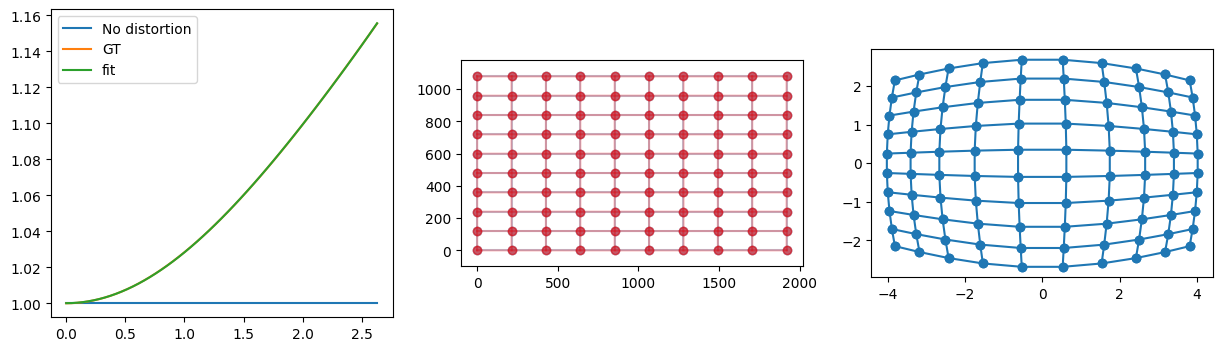

In [ ]:
import scipy


def get_r2_distortion_factor(
    distortion_coeffs: np.ndarray, r2: np.ndarray
) -> np.ndarray:
    k1, k2, k3 = distortion_coeffs
    r4 = r2 * r2
    r6 = r4 * r2
    factor = 1 + k1 * r2 + k2 * r4 + k3 * r6
    return factor


def distort_points(
    distortion_coeffs: np.ndarray, points_in_camera: np.ndarray
) -> np.ndarray:
    np.testing.assert_equal(points_in_camera.shape[-1], 3)
    shape0 = points_in_camera.shape
    points_in_camera = points_in_camera.reshape((-1, 3))

    x = points_in_camera[:, 0]
    y = points_in_camera[:, 1]
    z = points_in_camera[:, 2]
    r = np.sqrt(x**2 + y**2)

    psi = np.atan2(y, x)
    theta = np.atan2(r, z)

    theta2 = theta * theta
    factor = get_r2_distortion_factor(distortion_coeffs, theta2)
    thetad = theta * factor

    rd = np.tan(thetad) * z
    yd = rd * np.sin(psi)
    xd = rd * np.cos(psi)

    return np.stack([xd, yd, z], axis=1).reshape(shape0)


def fit_undistort_poly_debug(
    distortion_coeffs: np.ndarray, K: np.ndarray, width: int, height: int
):
    corners_image = np.array(
        [(0, 0), (0, height - 1), (width - 1, 0), (width - 1, height - 1)]
    )
    corners_dist = hmult(np.linalg.inv(K), corners_image)
    corners_thetad = np.atan2(corners_dist[:, 1], corners_dist[:, 0])
    max_thetad = np.max(corners_thetad)

    res = scipy.optimize.minimize(
        lambda x: (max_thetad - x * get_r2_distortion_factor(distortion_coeffs, x * x))
        ** 2,
        x0=max_thetad,
    )

    # print(res)
    max_theta = res.x[0]
    # max_theta=max_thetad

    N = 50
    theta = np.linspace(0, max_theta, N)
    theta2 = theta**2
    factors = get_r2_distortion_factor(distortion_coeffs, theta2)

    thetad = theta * factors
    thetad2 = thetad**2

    poly = np.polynomial.Polynomial.fit(thetad2, factors, 3)
    return poly, (theta, factors, thetad)


def fit_undistort_poly(
    distortion_coeffs: np.ndarray, K: np.ndarray, width: int, height: int
) -> np.polynomial.Polynomial:
    p, _ = fit_undistort_poly_debug(distortion_coeffs, K, width, height)
    return p


def undistort_points(
    undistort_poly: np.polynomial.Polynomial | None,
    points_in_dist: np.ndarray,
) -> np.ndarray:
    if undistort_poly is None:
        return points_in_dist

    np.testing.assert_equal(points_in_dist.shape[-1], 3)
    shape0 = points_in_dist.shape
    points_in_dist = points_in_dist.reshape((-1, 3))

    xd = points_in_dist[:, 0]
    yd = points_in_dist[:, 1]
    z = points_in_dist[:, 2]
    rd = np.sqrt(xd**2 + yd**2)

    psi = np.atan2(yd, xd)
    thetad = np.atan2(rd, z)

    factor = undistort_poly(thetad**2)
    # print("Undist=",factor)

    theta = thetad / factor
    r = np.tan(theta) * z
    x = r * np.cos(psi)
    y = r * np.sin(psi)
    return np.stack([x, y, z], axis=1).reshape(shape0)


def get_image_outline_points(width, height, N):
    l2r = np.linspace(0, width - 1, N)
    b2t = np.linspace(0, height - 1, N)
    b = np.zeros_like(l2r)
    t = np.full_like(l2r, height - 1)
    l = np.zeros_like(b2t)
    r = np.full_like(b2t, width - 1)

    bl2br = np.stack([l2r, b], axis=1)
    br2tr = np.stack([r, b2t], axis=1)
    tr2tl = np.stack([np.flip(l2r), t], axis=1)
    tl2bl = np.stack([l, np.flip(b2t)], axis=1)

    all = np.concatenate([bl2br, br2tr[1:], tr2tl[1:], tl2bl[1:]])
    return all


def test_distortion_model(dist_coef, K, width, height):
    undistort_poly, (fit_theta, fit_factors, fit_thetad) = fit_undistort_poly_debug(
        dist_coef, K, width, height
    )
    print(f"Poly coef: {undistort_poly.coef}")

    _, axs = plt.subplots(1, 3, figsize=(15, 4))

    # Show undistortion poly
    ax = axs[0]
    ax.plot(
        fit_thetad,
        get_r2_distortion_factor([0, 0, 0], fit_theta**2),
        label="No distortion",
    )
    ax.plot(fit_thetad, fit_factors, label="GT")
    ax.plot(fit_thetad, undistort_poly(fit_thetad**2), label="fit")
    ax.legend()

    # points=get_image_outline_points(width,height,5)
    N = 10
    x = np.linspace(0, width - 1, N)
    y = np.linspace(0, height - 1, N)
    xv, yv = np.meshgrid(x, y)
    grid_shape = xv.shape
    points_image = np.stack([xv.reshape(-1), yv.reshape(-1)], axis=1)

    invK = np.linalg.inv(K)
    points_dist = hmult(invK, points_image, keep_h=True)
    points_undist = undistort_points(undistort_poly, points_dist)
    # points_undist = points_dist
    points_dist_exp = distort_points(dist_coef, points_undist)
    # points_dist_exp = points_undist
    points_image_exp = hmult(K, from_h(points_dist_exp))

    errors = np.linalg.norm(points_image - points_image_exp, axis=1)
    print(f"Errors: mean={np.mean(errors)}, max={np.max(errors)}")

    xv_undist = points_undist[:, 0].reshape(grid_shape)
    yv_undist = points_undist[:, 1].reshape(grid_shape)

    xv_exp = points_image_exp[:, 0].reshape(grid_shape)
    yv_exp = points_image_exp[:, 1].reshape(grid_shape)

    def plot_meshgrid(ax, xv, yv, fmt="o-", color="C0", *args, **kwargs):
        # Rows
        for i in range(xv.shape[0]):
            ax.plot(xv[i, :], yv[i, :], fmt, color=color, *args, **kwargs)
        # Cols
        for i in range(xv.shape[1]):
            ax.plot(xv[:, i], yv[:, i], fmt, color=color, *args, **kwargs)

    ax = axs[1]
    plot_meshgrid(ax, xv, yv, alpha=0.3)
    plot_meshgrid(ax, xv_exp, yv_exp, color="red", alpha=0.3)
    ax.set_xlim([-100, width + 100])
    ax.set_ylim([-100, height + 100])
    ax.set_aspect(1)
    ax = axs[2]
    plot_meshgrid(ax, xv_undist, yv_undist)
    # ax.set_xlim([-100,width+100])
    # ax.set_ylim([-100,height+100])
    ax.set_aspect(1)


# test_dist = [0.0000013,-0.000000000001,0]
test_dist = [0.03, 0, 0]
# test_dist = [-0.0000003,0,0]
# test_dist = [0,0,0]
center = np.array([width / 2, height / 2])
test_distortion_model(test_dist, test_K, width, height)

Error (submap units): mean=43.20943625915072, max=96.86583319980396, sum=432.0943625915072
Error (world units): mean=1.2192864672110564, max=2.733186099490582, sum=12.192864672110565
Error (camera units): mean=31.38301801152385, max=63.68281678266312, sum=313.8301801152385


array([<Axes: >, <Axes: >], dtype=object)

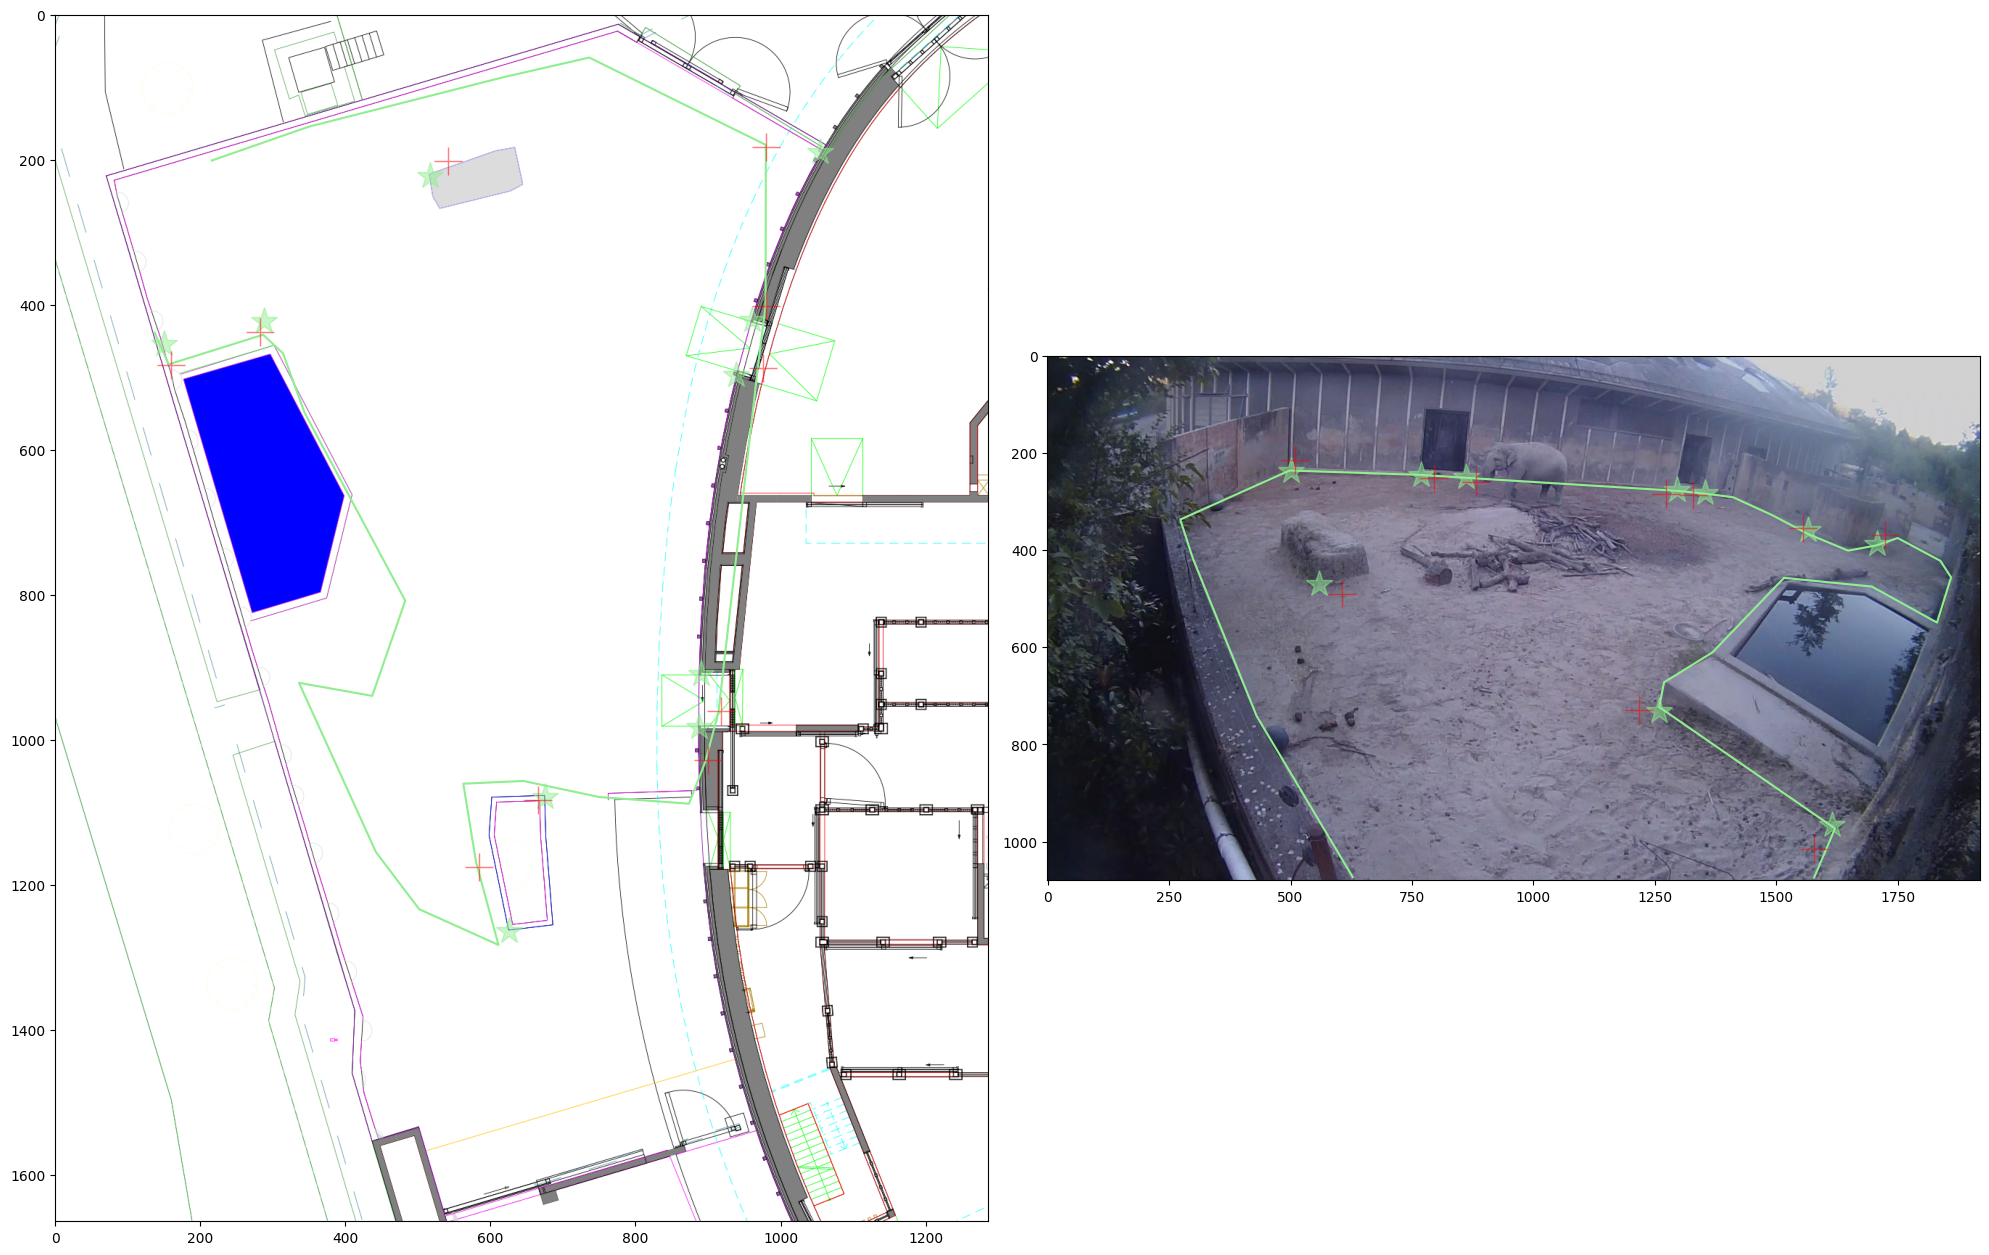

In [ ]:
def plot_projections(H_camera_from_world2:np.ndarray,K:np.ndarray|None=None, dist_coef:np.ndarray|None = None):
    H_world2_from_camera = np.linalg.inv(H_camera_from_world2)
    H_submap_from_camera = T_submap_from_world2 @H_world2_from_camera

    undistort_poly = fit_undistort_poly(dist_coef,K, width,height) if dist_coef is not None else None

    invK = np.linalg.inv(K) if K is not None else None

    def undistort(p_im):
        if K is not None:
            p_dist = hmult(invK,p_im,keep_h=True)
            p_undist = undistort_points(undistort_poly, p_dist)
            return p_undist[:,0:2]
        else:
            assert dist_coef is None
            return p_im

    def distort(p_cam):
        if K is not None:
            p_dist = distort_points(dist_coef,to_h(p_cam))
            p_cam = hmult(K, from_h(p_dist))
            return p_cam
        else: 
            assert dist_coef is None
            return p_cam

       
    floor_polygon_in_camera = camera_constraints.floor_polygon_in_camera
    camera_points =  camera_constraints.camera_points
    world2_points =  camera_constraints.world_points[:,0:2]

    floor_polygon_in_submap = hmult(H_submap_from_camera, undistort(floor_polygon_in_camera))
    submap_points = hmult(T_submap_from_world2, world2_points)
    camera_points_exp = distort(hmult(H_camera_from_world2, world2_points))
    submap_points_exp = hmult(H_submap_from_camera, undistort(camera_points))

    errors = np.linalg.norm(submap_points - hmult(H_submap_from_camera, camera_constraints.camera_points), axis=1)
    print(f"Error (submap units): mean={np.mean(errors)}, max={np.max(errors)}, sum={np.sum(errors)}")

    errors = np.linalg.norm(world2_points  - hmult(H_world2_from_camera, camera_constraints.camera_points), axis=1)
    print(f"Error (world units): mean={np.mean(errors)}, max={np.max(errors)}, sum={np.sum(errors)}")

    errors = np.linalg.norm(camera_constraints.camera_points -  hmult(H_camera_from_world2, camera_constraints.world_points[:,0:2]), axis=1)
    print(f"Error (camera units): mean={np.mean(errors)}, max={np.max(errors)}, sum={np.sum(errors)}")

    fig,axs = plt.subplots(1,2,figsize=(20,15))
    axs[0].imshow(im_submap)
    axs[1].imshow(im_camera)
    ax = axs[0]
    ax.plot(floor_polygon_in_submap[:,0],floor_polygon_in_submap[:,1],"-",color="lightgreen")
    ax = axs[1]
    ax.plot(floor_polygon_in_camera[:,0],floor_polygon_in_camera[:,1],"-",color="lightgreen")
    for i in range(camera_constraints.camera_points.shape[0]):
        ax = axs[0]
        ax.plot(submap_points[i,0],submap_points[i,1],"*",markersize=20, color="lightgreen",alpha=0.5)
        ax.plot(submap_points_exp[i,0],submap_points_exp[i,1],"+",markersize=20, color= "red",alpha=0.5)

        ax = axs[1]
        ax.plot(camera_points[i,0],camera_points[i,1],"*",markersize=20, color="lightgreen",alpha=0.5)
        ax.plot(camera_points_exp[i,0],camera_points_exp[i,1],"+",markersize=20, color="red",alpha=0.5)

    fig.tight_layout()
    return axs
# plot_projections(np.linalg.inv(test_K)@H_camera_from_world2, test_K, test_dist)
plot_projections(H_camera_from_world2)

Optimization cost: start=313.8301801152385, delta=-133.95005540154725
Cost at start : 313.8301801152385, delta=-133.95005540154725
h_model=HModel(H_camera_from_world2=array([[ 6.21450102e+00, -3.38369456e+01,  2.56098477e+03],
       [-2.39733468e+00, -4.23919474e+00,  1.58494400e+02],
       [ 1.62023170e-02, -1.17035271e-02,  2.36279548e+00]]))
Error (submap units): mean=37.493316751724976, max=138.77031017089456, sum=374.93316751724973
Error (world units): mean=1.0580300184782172, max=3.916296614132044, sum=10.580300184782171
Error (camera units): mean=17.988012471369125, max=84.89624094584993, sum=179.88012471369123


array([<Axes: >, <Axes: >], dtype=object)

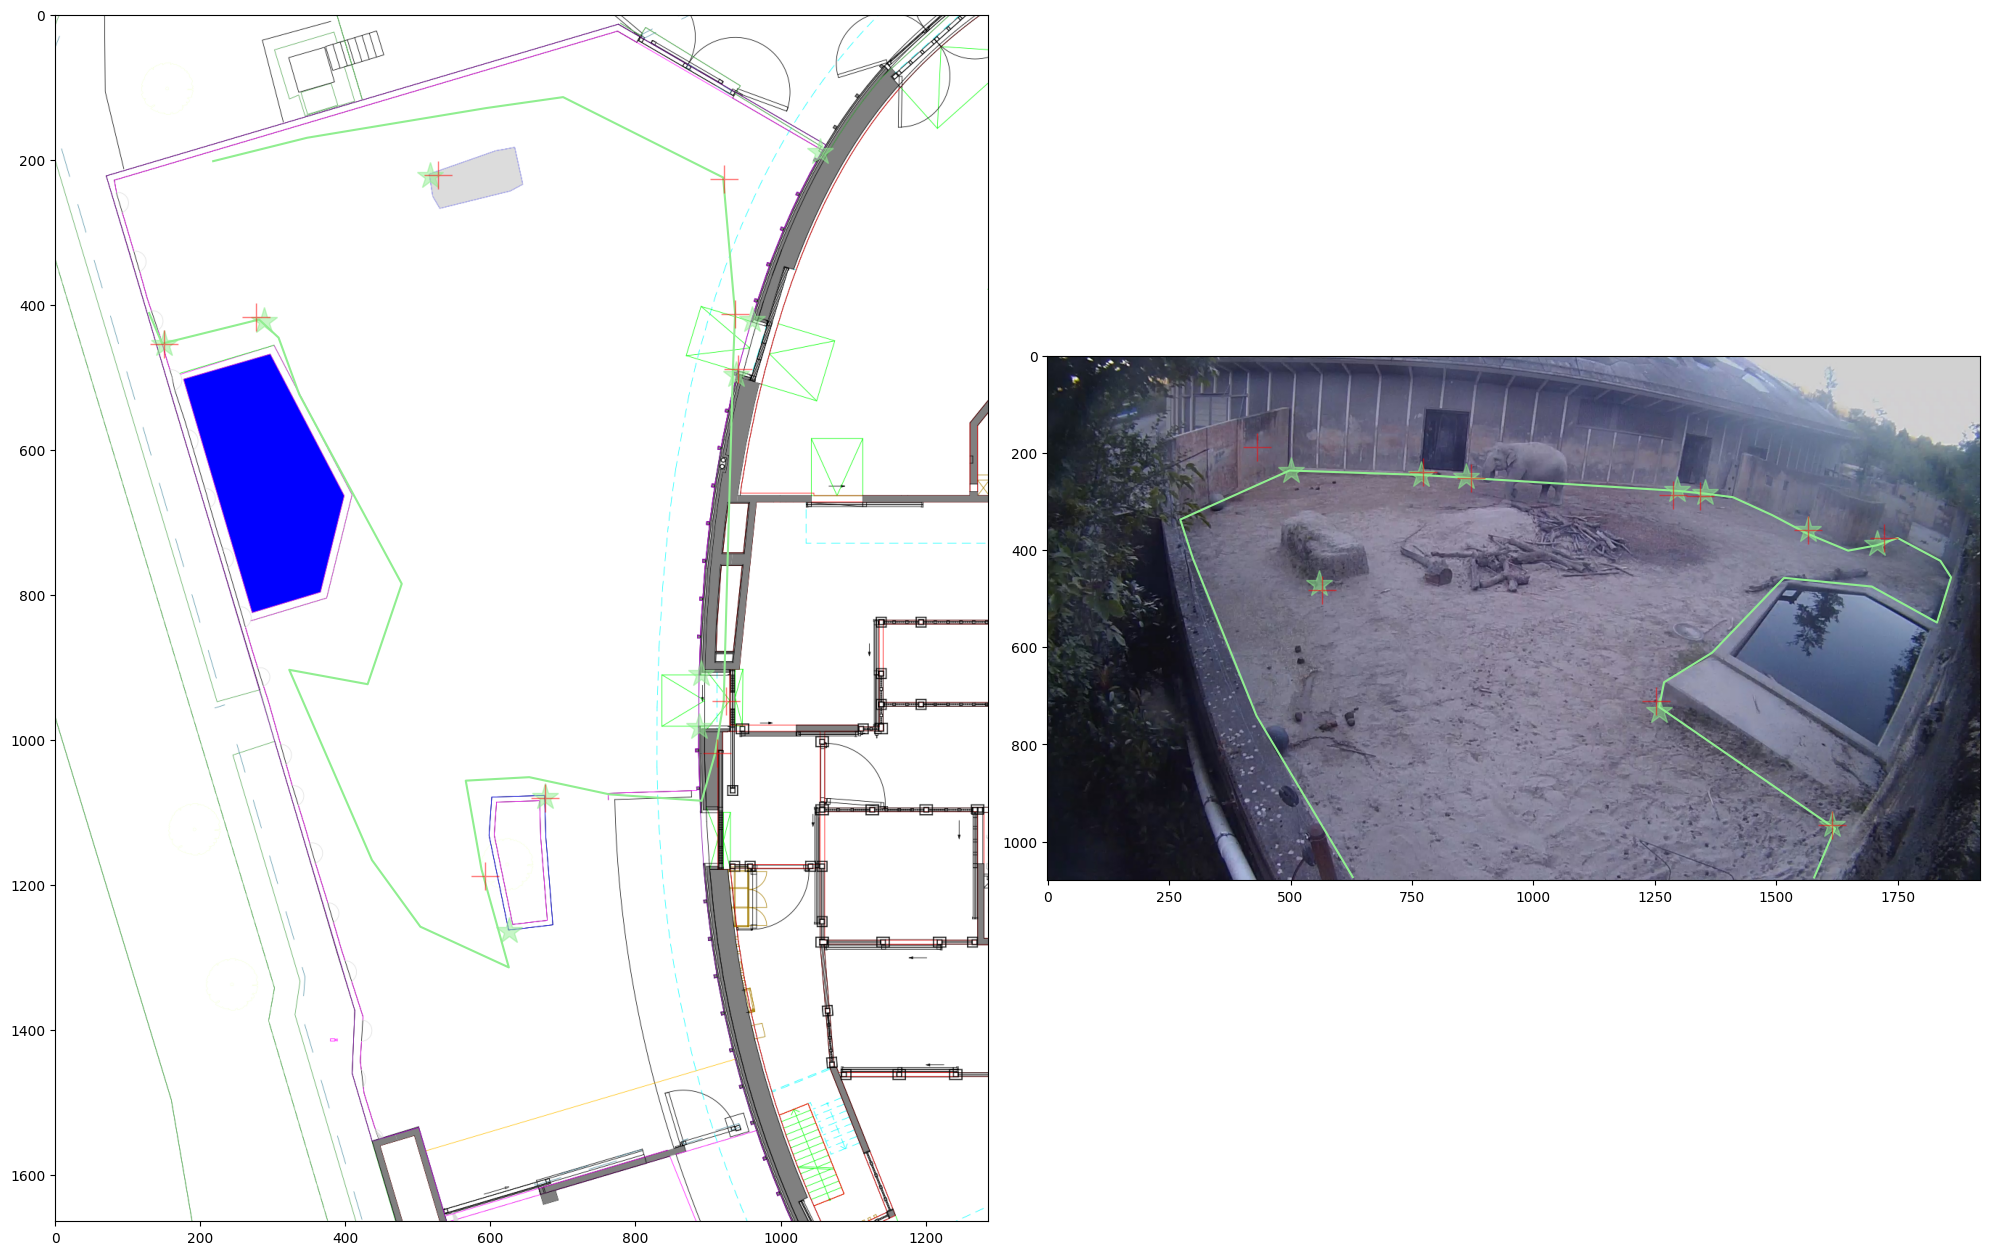

In [ ]:
# Optimize distortion+homography
import scipy.optimize
from optimization_helpers import optimizeModel, IModelEvaluator
from dataclasses import dataclass
import scipy


@dataclass
class HModel:
    H_camera_from_world2: np.ndarray


class HEvaluator(IModelEvaluator[HModel]):
    def __init__(self, model0: HModel):
        super().__init__()
        self.model0 = model0

    def model2params(self, model: HModel) -> np.ndarray:
        Hl = model.H_camera_from_world2.reshape(-1)
        params_list = [*Hl[:]]
        return np.array(params_list)

    def params2model(self, params: np.ndarray) -> HModel:
        H = params.reshape((3, 3))
        # H = self.model0.H_camera_from_world2
        model = HModel(
            H_camera_from_world2=H,
        )
        return model

    def getParamBounds(self) -> scipy.optimize.Bounds | None:
        return None

    def evaluateModel(self, model: HModel) -> float:
        world2_points = camera_constraints.world_points[:, 0:2]
        camera_points = camera_constraints.camera_points
        camera_points_exp = hmult(model.H_camera_from_world2, world2_points)
        errors = np.linalg.norm(camera_points - camera_points_exp, axis=1)

        return np.sum(errors)


h_model0 = HModel(H_camera_from_world2=H_camera_from_world2)
evaluator = HEvaluator(model0=h_model0)
cost0 = evaluator.evaluateModel(h_model0)

h_model = optimizeModel(evaluator, h_model0)

cost = evaluator.evaluateModel(h_model)
print(f"Cost at start : {cost0}, delta={cost-cost0}")
print(f"{h_model=}")

# H_exp = h_model0.make_H()
# errors = np.mean(np.linalg.norm(camera_constraints.camera_points -  hmult(H_exp, camera_constraints.world_points[:,0:2]), axis=1))
# print("Mean H direct error (camera units): ", errors)

# H_exp = h_model.make_H()
# errors = np.mean(np.linalg.norm(camera_constraints.camera_points -  hmult(H_exp, camera_constraints.world_points[:,0:2]), axis=1))
# print("Mean H direct error (camera units): ", errors)

# print("R norm errors: ", evaluator.get_norm_errors(h_model))

# test_distortion_model(hd_model.dist_coef,hd_model.center,width,height)
plot_projections(h_model.H_camera_from_world2)

[1533.5135646  -439.04889524]
[ 1.         -4.82842712 -4.82842712]


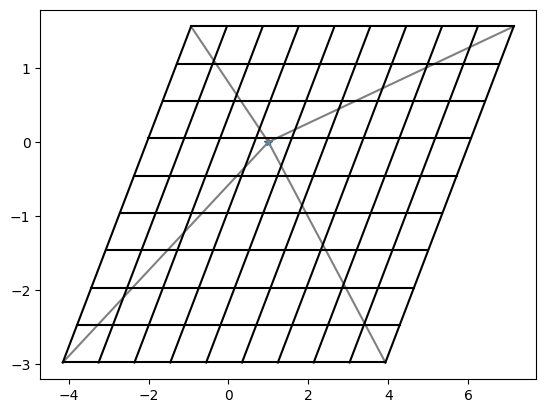

In [ ]:
@dataclass
class KRt:
    width: int
    height: int
    dist_coef: np.ndarray
    undistort_poly: np.polynomial.Polynomial
    K: np.ndarray
    R_world_from_camera: np.ndarray
    t_in_world: np.ndarray

    def __repr__(self):
        return f"dist_coef={self.dist_coef}\nK=\n{self.K}\nR_world_from_camera=\n{self.R_world_from_camera}\nt_in_world={self.t_in_world.T}"

    def get_center_in_world(self) -> np.ndarray:
        return self.t_in_world

    def project_points(self, points_in_world: np.ndarray) -> np.ndarray:
        R_camera_from_world = self.R_world_from_camera.T
        points_in_camera = (
            R_camera_from_world @ (points_in_world - self.t_in_world).T
        ).T
        points_in_dist = distort_points(self.dist_coef, points_in_camera)
        points_in_image = hmult(self.K, from_h(points_in_dist))
        return points_in_image

    def unproject_points(self, points_in_image: np.ndarray, depth=1) -> np.ndarray:
        invK = np.linalg.inv(self.K)

        points_in_dist = hmult(invK, points_in_image, keep_h=True)
        points_in_camera = undistort_points(self.undistort_poly, points_in_dist)
        world_points = (
            self.R_world_from_camera @ points_in_camera.T
        ).T * depth + self.t_in_world
        return world_points


def plot_camera(ax, model: KRt, scale=1, T_image_from_world: np.ndarray | None = None):
    center = model.get_center_in_world().squeeze()
    h, w = model.height, model.width

    N = 10
    u = np.linspace(0, w - 1, N)
    v = np.linspace(0, h - 1, N)
    uv, vv = np.meshgrid(u, v)
    grid_shape = uv.shape
    points_image = np.stack([uv.reshape(-1), vv.reshape(-1)], axis=1)

    xyz = model.unproject_points(points_image, scale)

    # Drop z
    xy = xyz[:, 0:2]

    if T_image_from_world is not None:
        xy = hmult(T_image_from_world, xy)

    # Back to grid
    xv = xy[:, 0].reshape(grid_shape)
    yv = xy[:, 1].reshape(grid_shape)

    ax.plot([center[0]], [center[1]], "*")
    for i, j in [(0, 0), (0, -1), (-1, -1), (-1, 0)]:
        ax.plot([center[0], xv[i, j]], [center[1], yv[i, j]], "-", color="gray")
    # Rows
    for i in range(xv.shape[0]):
        ax.plot(xv[i, :], yv[i, :], "-", color="black")
    # Cols
    for i in range(xv.shape[1]):
        ax.plot(xv[:, i], yv[:, i], "-", color="black")


R = scipy.spatial.transform.Rotation.from_euler(
    seq="xyz", angles=[np.pi / 4, np.pi / 4, 0]
).as_matrix()
# print(R)
dummy_dist = np.array([0, 0, 0])
dummy_model = KRt(
    width=width,
    height=height,
    dist_coef=dummy_dist,
    undistort_poly=fit_undistort_poly(dummy_dist, test_K, width, height),
    K=test_K,
    R_world_from_camera=R,
    t_in_world=np.array([1, 0, 0]),
)
_, ax = plt.subplots(1, 1)
p = np.array([1, -1, -1])
x = dummy_model.project_points(p)
print(x)
pp = dummy_model.unproject_points(x)
print(pp)
plot_camera(ax, dummy_model, scale=1)

In [ ]:
def make_H(K: np.ndarray, R: np.ndarray, t: np.ndarray):
    Rt = np.concatenate([R[:, [0, 1]], t.reshape((3, 1))], axis=1)
    Hp = K @ Rt
    return Hp


def make_H_camera_from_world2(camera: KRt):
    R_camera_from_world = camera.R_world_from_camera.T
    t_in_camera = -R_camera_from_world @ camera.t_in_world
    return make_H(camera.K, R_camera_from_world, t_in_camera)


make_H_camera_from_world2(dummy_model)

array([[ 5.98778548e+02, -6.78822510e+02, -5.98778548e+02],
       [ 3.53989117e+02, -2.63059114e+02, -3.53989117e+02],
       [ 5.00000000e-01, -7.07106781e-01, -5.00000000e-01]])

First R approximation
R=
[[-0.49709989 -1.20295134  0.04603494]
 [-0.59326881  0.11074425 -0.22627038]
 [ 0.1448571  -0.10463559 -0.76872447]]
Det=0.6442548095180771
t=[ 15.5788003  -59.47359786  21.12461465]
Error (submap units): mean=37.493316751724855, max=138.77031017089612, sum=374.93316751724853
Error (world units): mean=1.058030018478213, max=3.9162966141320887, sum=10.58030018478213
Error (camera units): mean=17.988012471369473, max=84.89624094585055, sum=179.88012471369473


array([<Axes: >, <Axes: >], dtype=object)

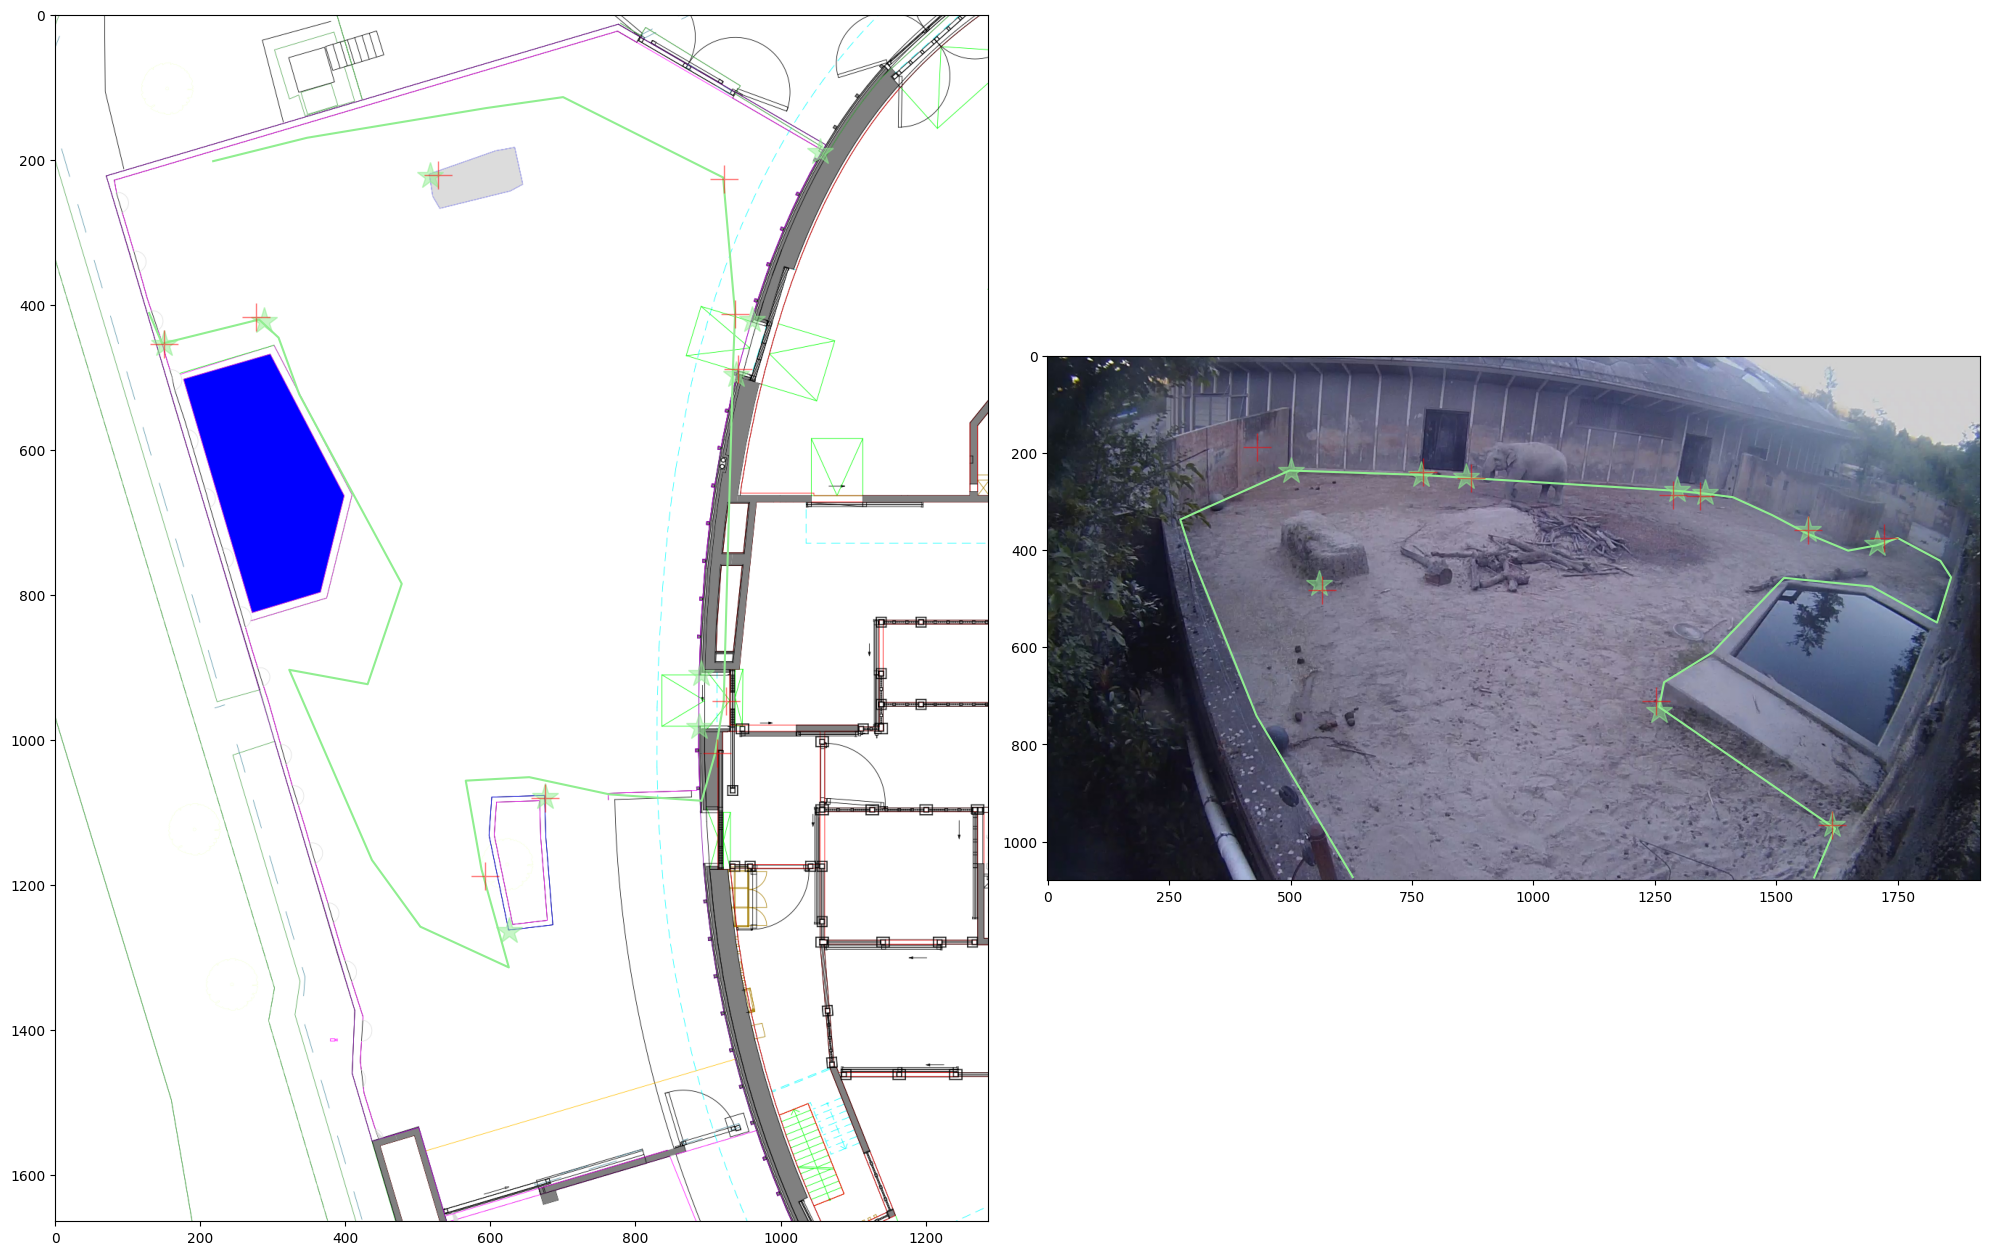

In [ ]:
# Decompose homography into K*[R|t]
# Construct a default K matrix
fov = 170 * np.pi / 180  # Assume our cameras have a wide fov
K0 = K_from_fov(fov, np.array([width / 2, height / 2]), width)
invK0 = np.linalg.inv(K0)
# print(f"{K0=}")

Rt = invK0 @ h_model.H_camera_from_world2
# print(f"Rt=\n{Rt}")

factor = np.mean([np.linalg.norm(Rt[:, 0]), np.linalg.norm(Rt[:, 1])])
Rt /= factor
r1 = Rt[:, 0]
r2 = Rt[:, 1]
r3 = np.cross(r1, r2)
R = np.stack([r1, r2, r3]).T
# print(r1)
t = Rt[:, 2]
print("First R approximation")
print(f"R=\n{R}")
print(f"Det={np.linalg.det(R)}")
print(f"t={t.T}")
# W,U,Vt=cv2.SVDecomp(R)
# R = U@Vt
# print("Second R approximation")
# print(R)
# print(f"Det={np.linalg.det(R)}")

H_exp = make_H(K0, R, t)
plot_projections(H_exp)
# errors = np.mean(np.linalg.norm(camera_constraints.camera_points -  hmult(H_exp, camera_constraints.world_points[:,0:2]), axis=1))
# print("Mean H direct error (camera units): ", errors)

# camera_in_world = KRt(width=width,height=height,dist_coef=hd_model.dist_coef,K=K0,R_world_from_camera=R.T,t_in_world=-R.T@t)
# print(camera_in_world)
# # T_camera_from_world = np.concatenate([R,t[:,None]],axis=1)
# # T_camera_from_world = np.concatenate([T_camera_from_world, [[0,0,0,1]]],axis=0)
# # T_world_from_camera = np.linalg.inv(T_camera_from_world)
# # print(f"T_camera_from_world=\n{T_camera_from_world}")
# # print(f"T_world_from_camera=\n{T_world_from_camera}")

# def homography_error(Ha,Hb):
#     sHa = np.linalg.norm(Ha.reshape((-1)))
#     sHb = np.linalg.norm(Hb.reshape((-1)))
#     Ha = Ha *sHb/sHa
#     cost = np.linalg.norm((Hb - Ha).reshape(-1))
#     return cost

Optimization cost: start=41339.77403921932, delta=-36063.8665622256
rt_model=RtModel(K=array([[ 43.25326371,   0.        , 887.74486231],
       [  0.        ,  29.44481862, 809.81107542],
       [  0.        ,   0.        ,   1.        ]]), dist_coef=array([0., 0., 0.]), R=array([[-0.30922606, -0.95038797],
       [-0.94468644,  0.31044019],
       [ 0.03121478, -0.01973839]]), t=array([  20.69821849, -106.42377771,    4.36560628]))
R norm errors:  [5.50133671e-03 8.32877545e-10 3.75097058e-08]
Error (submap units): mean=19769.858849914726, max=91384.86558390514, sum=197698.58849914727
Error (world units): mean=557.8421863096535, max=2578.5823241289777, sum=5578.421863096534
Error (camera units): mean=1237.1251395028617, max=1863.909833280493, sum=12371.251395028616


array([<Axes: >, <Axes: >], dtype=object)

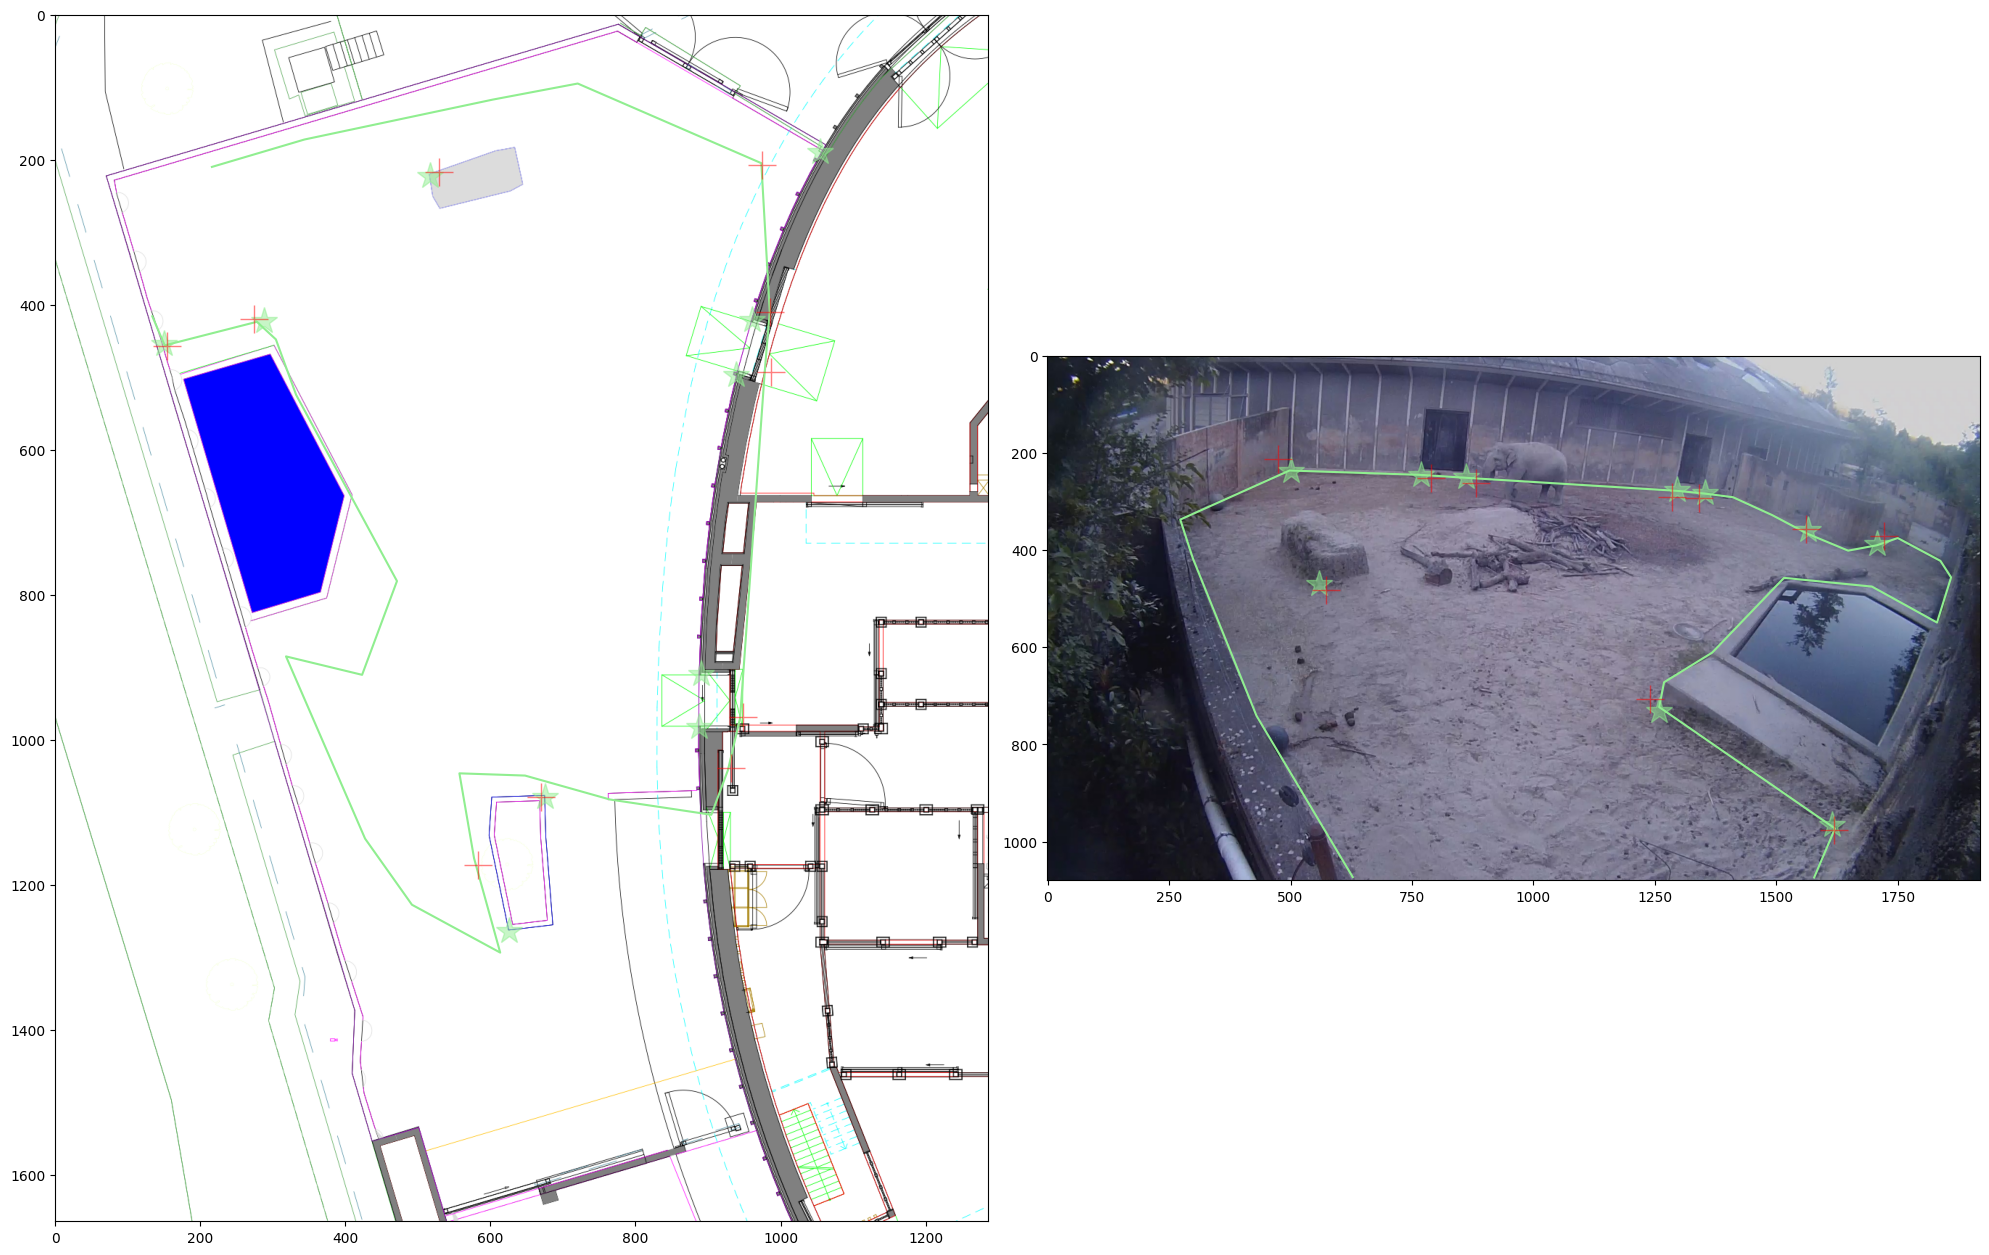

In [ ]:
import scipy.optimize
from optimization_helpers import optimizeModel, IModelEvaluator
from dataclasses import dataclass
import scipy


@dataclass
class RtModel:
    K: np.ndarray
    dist_coef: np.ndarray
    R: np.ndarray
    t: np.ndarray

    def make_H(self):
        return make_H(self.K, self.R, self.t)


class RtEvaluator(IModelEvaluator[RtModel]):
    def __init__(self, model0: RtModel):
        super().__init__()
        self.model0 = model0
        self.fix_dist = True

    def model2params(self, model: RtModel) -> np.ndarray:
        fx = model.K[0, 0]
        alpha = model.K[1, 1] / fx
        cx = model.K[0, 2]
        cy = model.K[1, 2]
        r1x, r1y, r1z = model.R[:, 0]
        r2x, r2y, r2z = model.R[:, 1]
        tx, ty, tz = model.t.reshape((3,))

        params_list = [
            fx,
            alpha,
            cx,
            cy,
            r1x,
            r1y,
            r1z,
            r2x,
            r2y,
            r2z,
            tx,
            ty,
            tz,
        ]
        if not self.fix_dist:
            k1, k2, k3 = model.dist_coef
            params_list.extend([k1, k2, k3])
        return np.array(params_list)

    def params2model(self, params: np.ndarray) -> RtModel:
        if self.fix_dist:
            fx, alpha, cx, cy, r1x, r1y, r1z, r2x, r2y, r2z, tx, ty, tz = params
            dist_coef = self.model0.dist_coef
        else:
            fx, alpha, cx, cy, r1x, r1y, r1z, r2x, r2y, r2z, tx, ty, tz, k1, k2, k3 = (
                params
            )
            dist_coef = np.array([k1, k2, k3])

        K = np.array([[fx, 0, cx], [0, fx * alpha, cy], [0, 0, 1]])
        R = np.array(
            [
                [r1x, r1y, r1z],
                [
                    r2x,
                    r2y,
                    r2z,
                ],
            ]
        ).T
        t = np.array([tx, ty, tz])
        model = RtModel(dist_coef=dist_coef, K=K, R=R, t=t)
        return model

    def getParamBounds(self) -> scipy.optimize.Bounds | None:
        return None

    def get_norm_errors(self, model: RtModel) -> np.ndarray:
        r1 = model.R[:, 0]
        r2 = model.R[:, 1]
        error_norm1 = np.abs((1 - np.linalg.norm(r1)))
        error_norm2 = np.abs((1 - np.linalg.norm(r2)))
        error_prod = np.abs(np.dot(r1, r2))
        return np.array([error_norm1, error_norm2, error_prod])

    def evaluateModel(self, model: RtModel) -> float:
        world2_points = camera_constraints.world_points[:, 0:2]
        camera_points = camera_constraints.camera_points

        points_in_camera = (model.R @ world2_points.T).T + model.t.reshape([1, 3])
        points_in_dist = distort_points(model.dist_coef, points_in_camera)
        points_in_image_exp = hmult(model.K, from_h(points_in_dist))
        errors_in_camera = np.sum((camera_points - points_in_image_exp) ** 2, axis=1)

        poly = fit_undistort_poly(model.dist_coef, model.K, width, height)
        points_in_dist = hmult(np.linalg.inv(model.K), camera_points, keep_h=True)
        points_in_camera = undistort_points(poly, points_in_dist)
        points_in_world_exp = (
            model.R.T @ (points_in_camera - model.t.reshape([1, 3])).T
        ).T
        errors_in_world2 = np.sum(
            (world2_points - points_in_world_exp[:, 0:2]) ** 2, axis=1
        )

        return (
            np.sum(errors_in_camera)
            + np.sum(errors_in_world2)
            + 1000 * np.sum(self.get_norm_errors(model))
        )


rt_model0 = RtModel(dist_coef=np.zeros((3,)), K=K0, R=R[:, 0:2], t=t)
evaluator = RtEvaluator(model0=rt_model0)
rt_model_nodist = optimizeModel(evaluator, rt_model0)
# evaluator.fix_dist =False
# rt_model = optimizeModel(evaluator, rt_model_nodist)
rt_model = rt_model_nodist
print(f"{rt_model=}")

# errors = np.mean(
#     np.linalg.norm(
#         camera_constraints.camera_points
#         - hmult(H_exp, camera_constraints.world_points[:, 0:2]),
#         axis=1,
#     )
# )
# print("Mean H direct error (camera units): ", errors)

# H_exp = h_model.make_H()
# errors = np.mean(
#     np.linalg.norm(
#         camera_constraints.camera_points
#         - hmult(H_exp, camera_constraints.world_points[:, 0:2]),
#         axis=1,
#     )
# )
# print("Mean H direct error (camera units): ", errors)

print("R norm errors: ", evaluator.get_norm_errors(rt_model))

H_rtModel = make_H(np.eye(3), rt_model.R, rt_model.t)
plot_projections(H_rtModel, rt_model.K, rt_model.dist_coef)
# test_distortion_model(rt_model.dist_coef, rt_model.K, width,height)

No distortion
Camera height: 1.612306611067822
Error (submap units): mean=3114.168959168103, max=5539.4429403692775, sum=31141.689591681028
Error (world units): mean=87.87287611155874, max=156.32263371284822, sum=878.7287611155874
Error (camera units): mean=1238.5545435138272, max=1877.7753952232779, sum=12385.545435138272


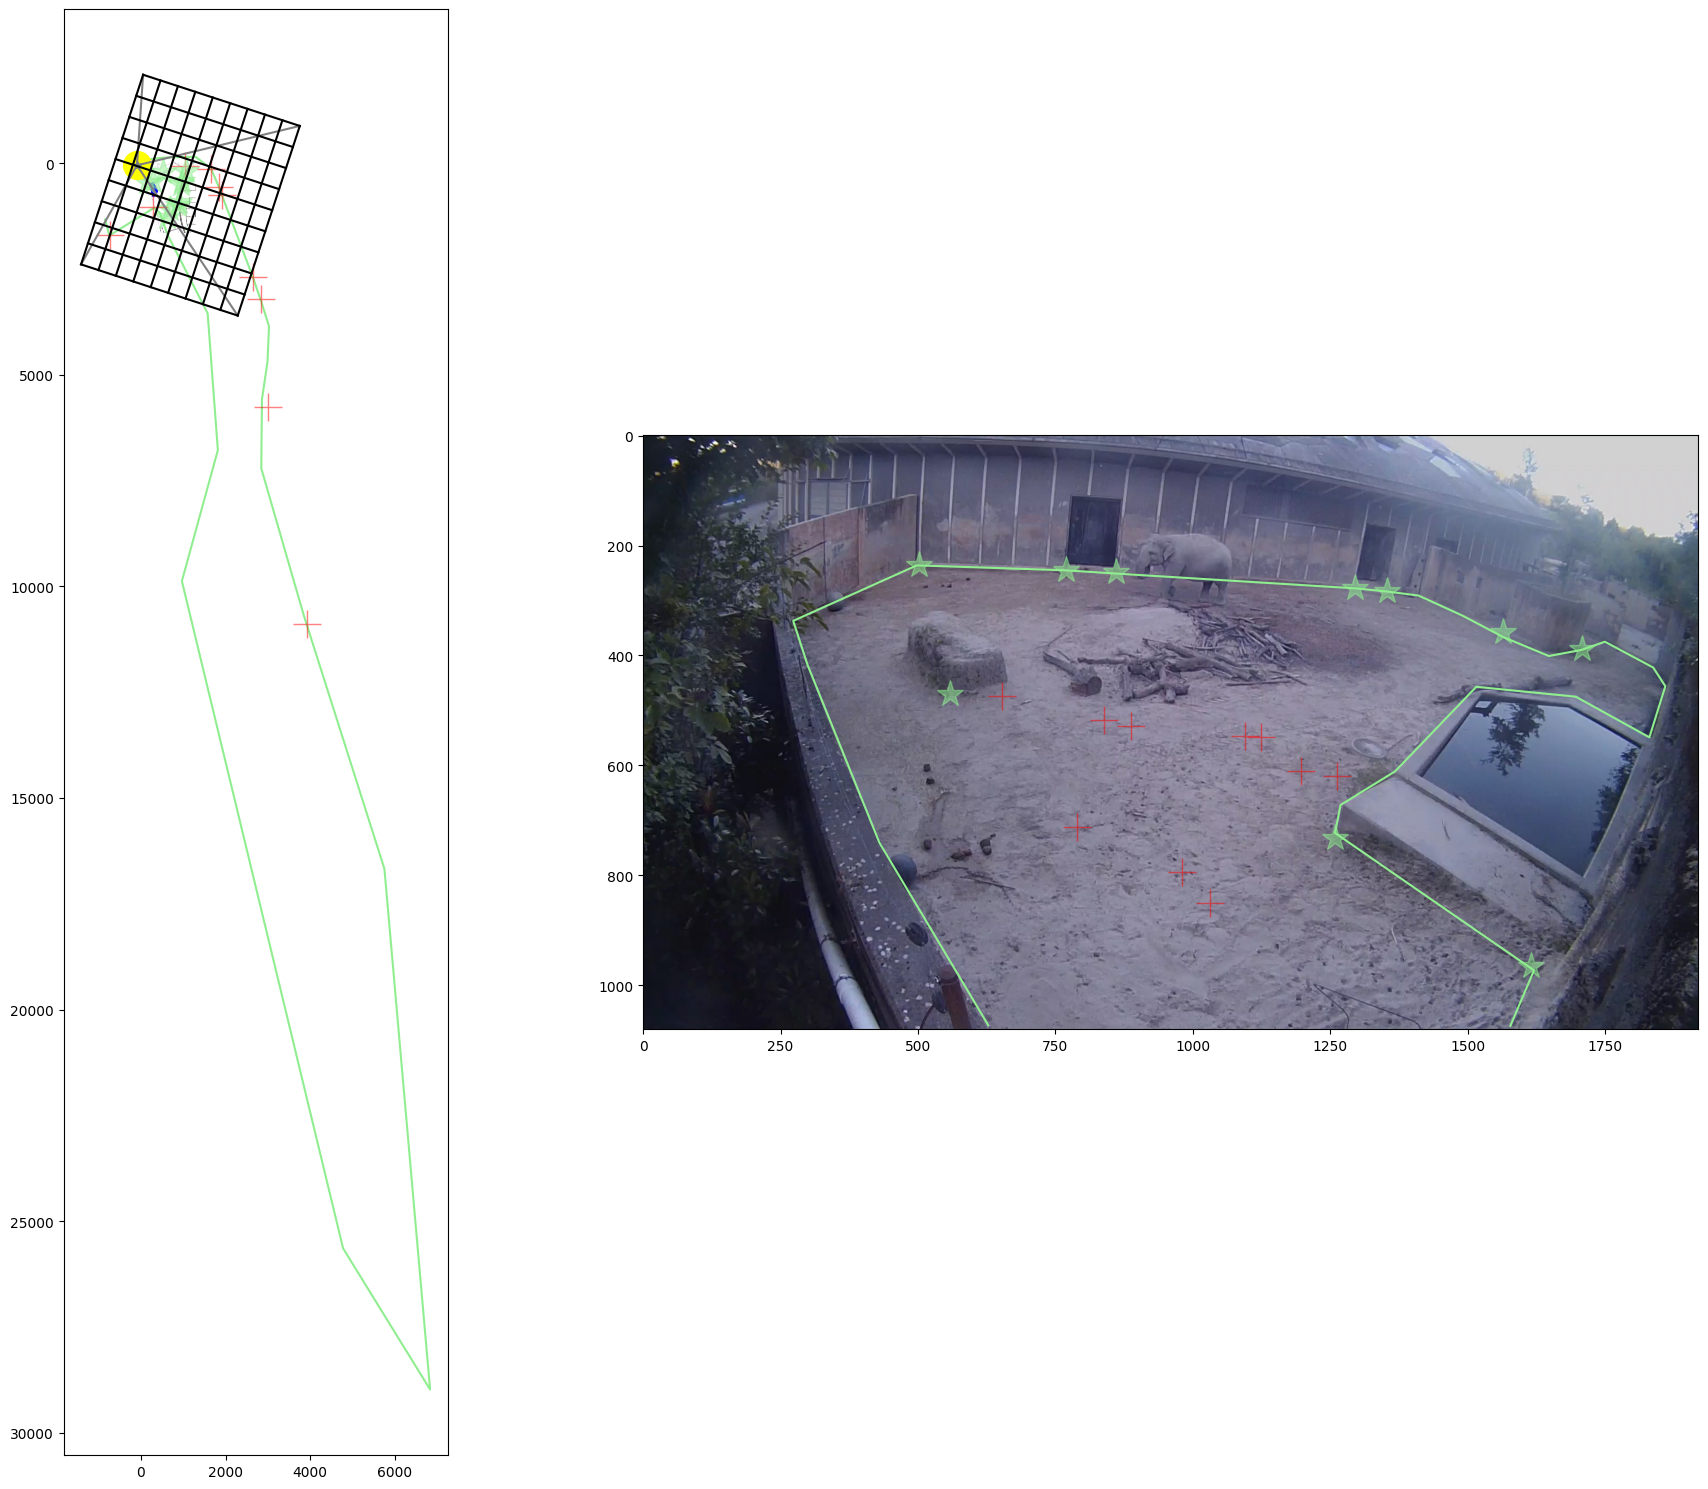

In [ ]:
def test_camera(camera_in_world: KRt):
    if np.all(camera_in_world.dist_coef == 0.0):
        print("No distortion")
    else:
        test_distortion_model(
            camera_in_world.dist_coef, camera_in_world.K, width, height
        )
    print(f"Camera height: {camera_in_world.t_in_world[2]}")

    H_dist_from_world2_exp = np.linalg.inv(
        camera_in_world.K
    ) @ make_H_camera_from_world2(camera_in_world)
    axs = plot_projections(
        H_dist_from_world2_exp, camera_in_world.K, camera_in_world.dist_coef
    )

    camera_center_in_world = camera_in_world.get_center_in_world()
    # world2_points_exp = evaluator.compute_world_points(model)[:, 0:2]
    # submap_points_exp = hmult(T_submap_from_world2, world2_points_exp)
    # camera_points_exp = model.project_points(world_points)

    # fig, axs = plt.subplots(1, 2, figsize=(20, 15))
    # axs[0].imshow(im_submap)
    # axs[1].imshow(im_camera)
    # for i in range(camera_constraints.camera_points.shape[0]):
    #     cp = camera_constraints.camera_points[i]
    #     wp = submap_points[i]
    #     cp2 = camera_points_exp[i]
    #     wp2 = submap_points_exp[i]
    #     c = f"C{i}"
    #     axs[0].plot(wp[0], wp[1], "*", markersize=20, color=c)
    #     axs[0].plot(wp2[0], wp2[1], "+", markersize=20, color=c)
    #     axs[1].plot(cp[0], cp[1], "*", markersize=20, color=c)
    #     axs[1].plot(cp2[0], cp2[1], "+", markersize=20, color=c)
    axs[0].plot(
        camera_center_in_world[0],
        camera_center_in_world[1],
        "o",
        markersize=20,
        color="yellow",
    )
    plot_camera(
        axs[0], camera_in_world, scale=3, T_image_from_world=T_submap_from_world2
    )


def force_orthonormal_rotation(R2):
    r1 = R2[:, 0]
    r2 = R2[:, 1]
    r3 = np.cross(r1, r2)
    R0 = np.stack([r1, r2, r3])
    W, U, Vt = cv2.SVDecomp(R0)
    Rfix = U @ Vt
    return Rfix


def camera_from_rtmodel(rtmodel: RtModel):
    dist_coef = rtmodel.dist_coef
    K = rtmodel.K
    R = force_orthonormal_rotation(rtmodel.R)
    t = rtmodel.t
    undistort_poly = fit_undistort_poly(dist_coef, K, width, height)
    return KRt(
        width=width,
        height=height,
        dist_coef=dist_coef,
        undistort_poly=undistort_poly,
        K=K,
        R_world_from_camera=R.T,
        t_in_world=-R.T @ t,
    )
    # return KRt(width=width,height=height,r_distortion=1,K=K,R_world_from_camera=R,t_in_world=t)


# H_exp = make_H(h_model.K, Rfix, h_model.t)
# errors = np.mean(np.linalg.norm(camera_constraints.camera_points -  hmult(H_exp, camera_constraints.world_points[:,0:2]), axis=1))
# print("Mean H direct error (camera units): ", errors)
# plot_projections(H_exp)
camera_from_decomposition = camera_from_rtmodel(rt_model)
test_camera(camera_from_decomposition)
# plot_projections(make_H_camera_from_world2(camera_from_decomposition))

Optimization cost: start=17579197.10029798, delta=-17564992.767823488
model=dist_coef=[0. 0. 0.]
K=
[[1.23920957e+03 0.00000000e+00 9.21035579e+02]
 [0.00000000e+00 1.23920957e+03 6.16602642e+01]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
R_world_from_camera=
[[-0.38622177 -0.13687858  0.91219351]
 [-0.91265496 -0.08670756 -0.39942799]
 [ 0.13376721 -0.98678572 -0.09143456]]
t_in_world=[-105.17058046   58.27074883    7.98758063]
camera_center_in_world=array([-105.17058046,   58.27074883,    7.98758063])
No distortion
Camera height: 7.987580627746887
Error (submap units): mean=2087.4762393164215, max=3755.225063700287, sum=20874.762393164216
Error (world units): mean=58.90676453421456, max=105.96572665059442, sum=589.0676453421456
Error (camera units): mean=1238.5868902004263, max=1880.4859680092284, sum=12385.868902004262


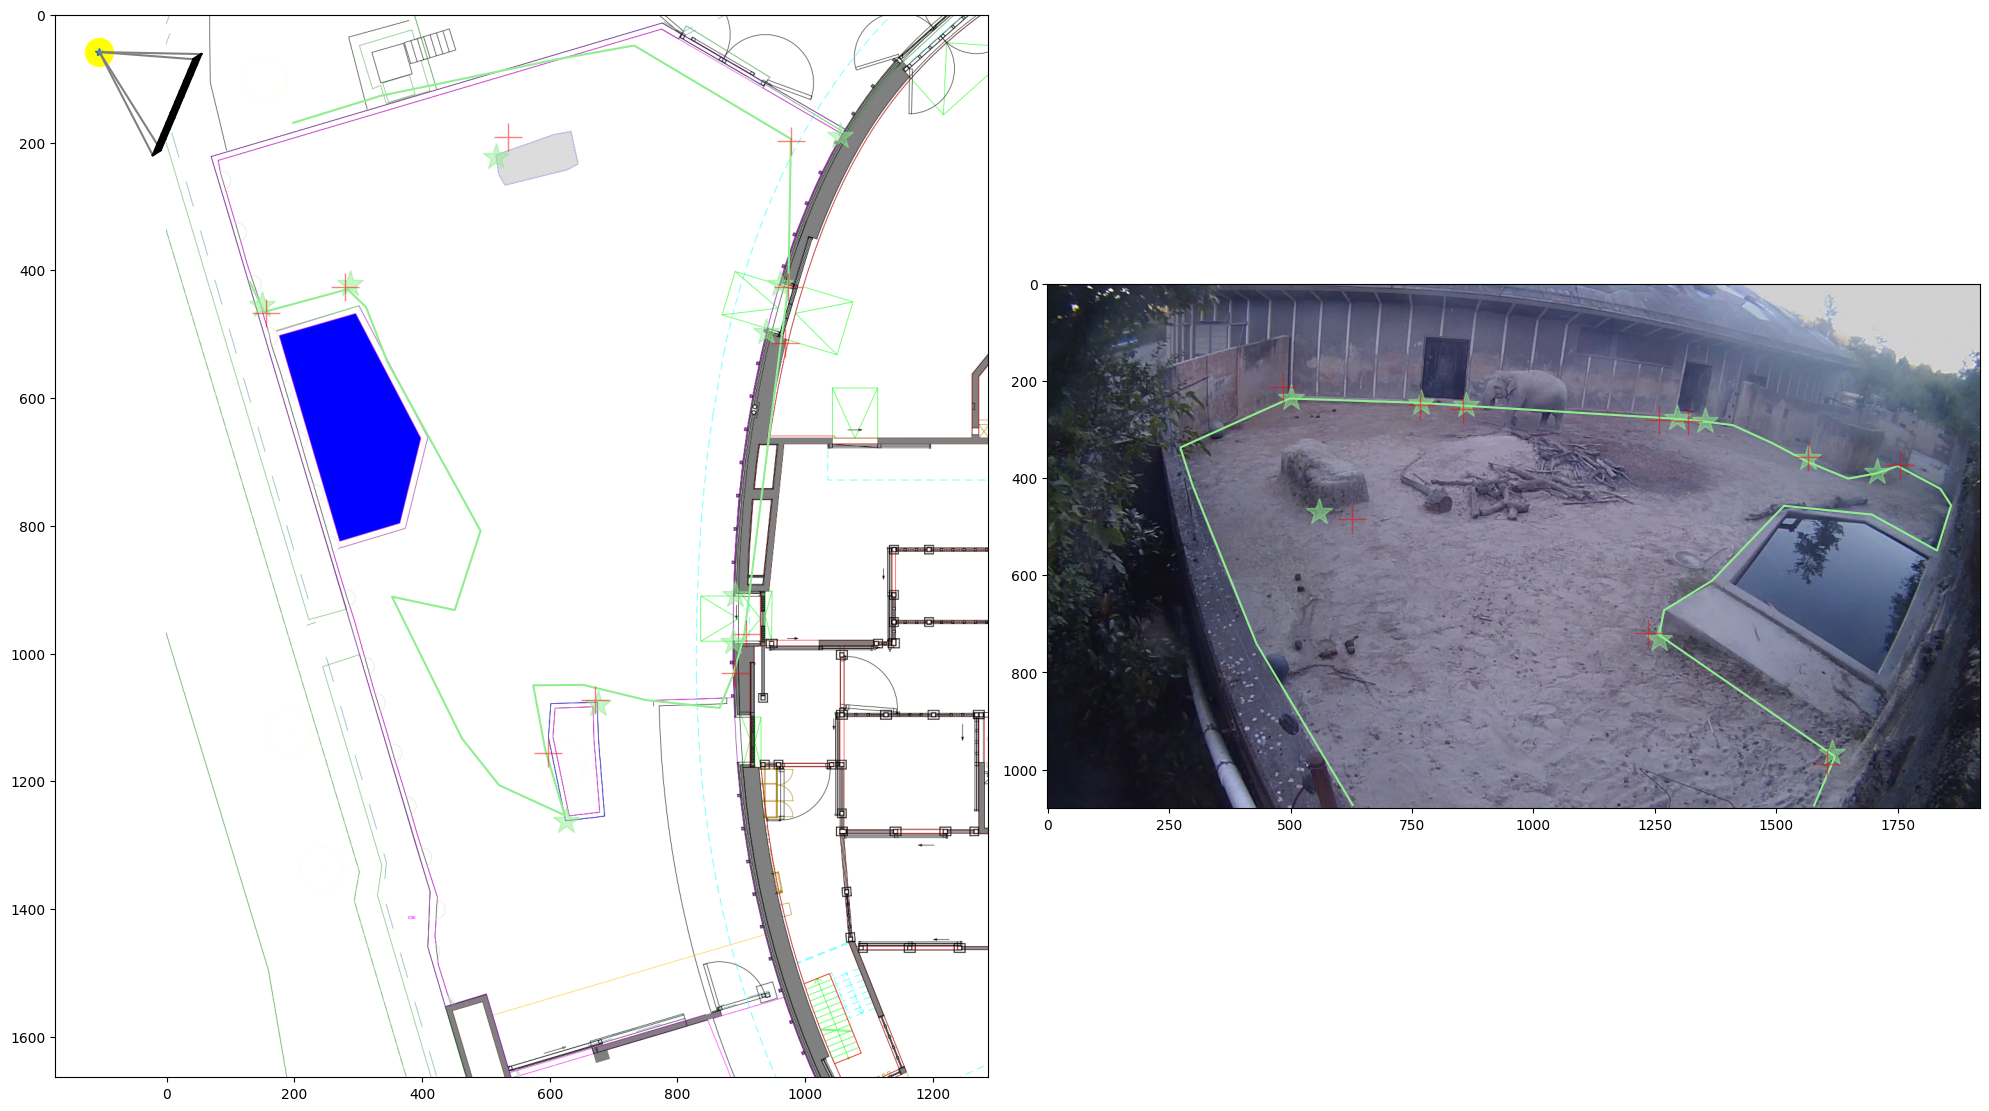

In [ ]:
FIXED_CAMERA_HEIGHT = 8


class ProjectionEvaluator(IModelEvaluator[KRt]):
    def __init__(
        self, camera_points: np.ndarray, world_points: np.ndarray, model0: KRt
    ):
        super().__init__()
        self.world_points = world_points
        self.camera_points = camera_points
        self.model0 = model0
        self.fix_dist = True

    def model2params(self, model: KRt) -> np.ndarray:
        rp, _ = cv2.Rodrigues(model.R_world_from_camera)
        rx, ry, rz = rp.reshape((3,))
        tx, ty, tz = model.t_in_world.reshape((3,))

        fx = model.K[0, 0]
        alpha = model.K[1, 1] / model.K[0, 0]
        cx = model.K[0, 2]
        cy = model.K[1, 2]

        k1, k2, k3 = model.dist_coef
        params_list = [fx, alpha, tz, cx, cy, rx, ry, rz, tx, ty, k1, k2, k3]
        return np.array(params_list)

    def params2model(self, params: np.ndarray) -> KRt:
        fx, alpha, tz, cx, cy, rx, ry, rz, tx, ty, k1, k2, k3 = params

        dist_coef = np.array([k1, k2, k3])
        R, _ = cv2.Rodrigues(np.array([rx, ry, rz]))
        t = np.array([tx, ty, tz])

        K = np.array([[fx, 0, cx], [0, fx * alpha, cy], [0, 0, 1]])

        # Fixed parameters
        # K[0,0] = self.model0.K[0,0]
        K[1, 1] = K[0, 0]
        # dist_coef[1] =0
        # dist_coef[2] =0
        if self.fix_dist:
            dist_coef = self.model0.dist_coef
        # K[2, 2] = 3

        model = KRt(
            width=self.model0.width,
            height=self.model0.height,
            dist_coef=dist_coef,
            undistort_poly=self.model0.undistort_poly,
            K=K,
            R_world_from_camera=R,
            t_in_world=t,
        )
        return model

    def getParamBounds(self) -> scipy.optimize.Bounds:
        params0 = self.model2params(self.model0)
        lb = np.full_like(params0, -np.inf)
        lb[0] = 0.1
        lb[1] = 0.1
        lb[2] = 0.0001
        return scipy.optimize.Bounds(lb=lb)

    def compute_world_points(self, model: KRt, debug=False) -> np.ndarray:
        center = model.get_center_in_world()

        world_points_d1 = model.unproject_points(self.camera_points)
        x_dir = world_points_d1 - center

        depth = -center[2] / x_dir[:, 2]
        world_points_exp = center + x_dir * depth[:, None]

        if debug:
            print(
                f"{self.camera_points=}\n{world_points_d1=}\n{x_dir=}\n{depth=}\n{world_points_exp=}"
            )
        return world_points_exp

    def compute_errors(self, model: KRt, debug=False) -> np.ndarray:
        world_points_exp = self.compute_world_points(model, debug)
        errors_world = self.world_points - world_points_exp
        # errors_submap = hmult(T_submap_from_world2, self.world_points[:,0:2]) - hmult(T_submap_from_world2, world_points_exp[:,0:2])

        camera_points_exp = model.project_points(self.world_points)
        errors_camera = self.camera_points - camera_points_exp

        return np.concatenate([10 * errors_world, errors_camera], axis=1)
        # return errors_camera

    def evaluateModel(self, model: KRt) -> float:
        return (
            np.sum(np.sum(self.compute_errors(model) ** 2, axis=1))
            + (model.t_in_world[2] - FIXED_CAMERA_HEIGHT) ** 2 * 100000
        )


# model0 = KRt(width=width, height=height, r_distortion=1, K=h_model.K, R_world_from_camera=h_model.R.T, t_in_world=-h_model.R.T@h_model.t)
model0 = camera_from_decomposition
evaluator = ProjectionEvaluator(
    camera_points=camera_constraints.camera_points,
    world_points=camera_constraints.world_points,
    model0=model0,
)
# display(m0)
errors0 = evaluator.compute_errors(model0)
# display(errors0)

cost0 = evaluator.evaluateModel(model0)
model_nodist = optimizeModel(evaluator, model0, debug=False)
cost_nodist = evaluator.evaluateModel(model_nodist)

evaluator.fix_dist = False
# model = optimizeModel(evaluator, model_nodist, debug=False)
model = model_nodist

# model=model0
# display("")
# print(f"Final errors: {evaluator.compute_errors(model,debug=False)}")
print(f"{model=}")

camera_center_in_world = model.get_center_in_world()
print(f"{camera_center_in_world=}")

# Display points
test_camera(model)
fig.tight_layout()

In [86]:
import json
from pathlib import Path

import scipy.spatial

config_file = Path("../data/config.json")
try:
    with config_file.open() as f:
        config = json.load(f)
except:
    config = {}

# Save map
config["map"] = {}
config["map"]["image"] = str(map_file)
config["map"]["T_map_from_world2"] = T_map_from_world2.tolist()


# Save cameras
if "cameras" not in config:
    config["cameras"] = {}
config["cameras"][camera_name] = {}
camera_config = config["cameras"][camera_name]

camera_config["sample_image"] = str(image_filename)
camera_config["intrinsics"] = {
    "width": width,
    "height": height,
    "K": model.K.tolist(),
    "distortion": model.dist_coef.tolist(),
    "undistortion": model.undistort_poly.coef.tolist(),
}
R_world_from_camera: scipy.spatial.transform.Rotation = (
    scipy.spatial.transform.Rotation.from_matrix(model.R_world_from_camera)
)
camera_config["T_world_from_camera"] = {
    "R": R_world_from_camera.as_quat(canonical=True, scalar_first=False).tolist(),
    "t_in_world": model.t_in_world.tolist(),
}
camera_config["H_world2_from_camera"] = np.linalg.inv(
    make_H_camera_from_world2(model)
).tolist()

config_json = json.dumps(config, indent=2)
print(config_json)

with config_file.open("w") as f:
    f.write(config_json)

{
  "map": {
    "image": "kkep_floorplan.png",
    "T_map_from_world2": [
      [
        35.4334161426658,
        0.0,
        4278.915070787953
      ],
      [
        0.0,
        -35.442265183206494,
        3656.779741115093
      ],
      [
        0.0,
        0.0,
        1.0
      ]
    ]
  },
  "models": {
    "segmentation2": "../models/camera0/segmentation/torch.pt",
    "segmentation": "../models/maskrcnn_trained.ptc"
  },
  "cameras": {
    "Kamera 01": {
      "sample_image": "cameras/Kamera 01/ELP-Kamera-01-20240907-185521-1725728121288-7_00000000_img.jpg",
      "intrinsics": {
        "width": 1920,
        "height": 1080,
        "K": [
          [
            1239.2095710302315,
            0.0,
            921.0355790270776
          ],
          [
            0.0,
            1239.2095710302315,
            61.6602642396381
          ],
          [
            0.0,
            0.0,
            1.0
          ]
        ],
        "distortion": [
          0.0,
  